<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformer**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

## **Resources**

1. ["Attention is all you need"](https://arxiv.org/pdf/1706.03762.pdf)

2. [Experiment with attention](https://colab.research.google.com/drive/1lFzBdEu5_vGB3rCoc-lF-X7UKNKX62OW?usp=sharing) (scaled dot product, multi-head attention, classifying MNIST with attention components)

3. [BERT Slide Deck](https://docs.google.com/presentation/d/1eCCT3uCTYXtfshJOJ0l74ZiA6WuWXjSqNP-i4qnDoXM/edit)

4. [„VATT: Transformers for Multimodal Self-Supervised Learning from Raw Video, Audio and Text“](https://arxiv.org/abs/2104.11178)

## **Attention**

Contributor: michaelmenzel

Various experiments which explore attention mechanisms and their influence on prediction accuracy and complexity.

In [2]:
q = tf.constant([[[1, 1], [1, 1]]], dtype=tf.float32)
q = k = v = tf.constant([[[50, 1], [2, 60]]], dtype=tf.float32)

[q, k, v]

[<tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
 array([[[50.,  1.],
         [ 2., 60.]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
 array([[[50.,  1.],
         [ 2., 60.]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
 array([[[50.,  1.],
         [ 2., 60.]]], dtype=float32)>]

### Scaled Dot Product Attention

In [3]:
tf.linalg.matmul(q, k, transpose_b=True)

<tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
array([[[2501.,  160.],
        [ 160., 3604.]]], dtype=float32)>

In [4]:
tf.linalg.matmul(q, k, transpose_b=True) / tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))

<tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
array([[[1768.4741  ,  113.137085],
        [ 113.137085, 2548.4128  ]]], dtype=float32)>

In [5]:
tf.nn.softmax(tf.linalg.matmul(q, k, transpose_b=True) / tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32)))

<tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
array([[[1., 0.],
        [0., 1.]]], dtype=float32)>

In [14]:
def scaled_dot_product_attention(q, k, v):
  d_k = tf.cast(tf.shape(k)[-1], tf.float32)
  return tf.linalg.matmul(tf.nn.softmax(tf.linalg.matmul(q, k, transpose_b=True) / tf.math.sqrt(d_k)), v)

In [7]:
scaled_dot_product_attention(q, k, v)

<tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
array([[[50.,  1.],
        [ 2., 60.]]], dtype=float32)>

### Multi-Head Attention

In [8]:
def multi_head_attention(q, k, v, d_model):
  qw = tf.keras.layers.Dense(d_model, use_bias=False)(q)
  kw = tf.keras.layers.Dense(d_model, use_bias=False)(k)
  vw = tf.keras.layers.Dense(d_model, use_bias=False)(v)
  return tf.keras.layers.Dense(d_model, use_bias=False)(scaled_dot_product_attention(qw, kw, vw))


In [9]:
multi_head_attention(q, k, v, 4)

<tf.Tensor: shape=(1, 2, 4), dtype=float32, numpy=
array([[[-38.89205  ,  -5.396014 ,  -7.1263976, -12.854862 ],
        [-38.89205  ,  -5.396014 ,  -7.1263976, -12.854862 ]]],
      dtype=float32)>

### MNIST Attention

In [10]:
import tensorflow_datasets as tfds

In [11]:
mnist_train, mnist_test = tfds.load("mnist", split=["train", "test"], as_supervised=True)

mnist_train = mnist_train.map(lambda x, y: (tf.squeeze(x/255, axis=-1), y))
mnist_train_batched = mnist_train.batch(128).prefetch(tf.data.AUTOTUNE)
mnist_test = mnist_test.map(lambda x, y: (tf.squeeze(x/255, axis=-1), y))
mnist_test_batched = mnist_test.batch(128).prefetch(tf.data.AUTOTUNE)

mnist_train_batched

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


<PrefetchDataset shapes: ((None, 28, 28), (None,)), types: (tf.float32, tf.int64)>

#### What does scaled dot product attention look like on MNIST?

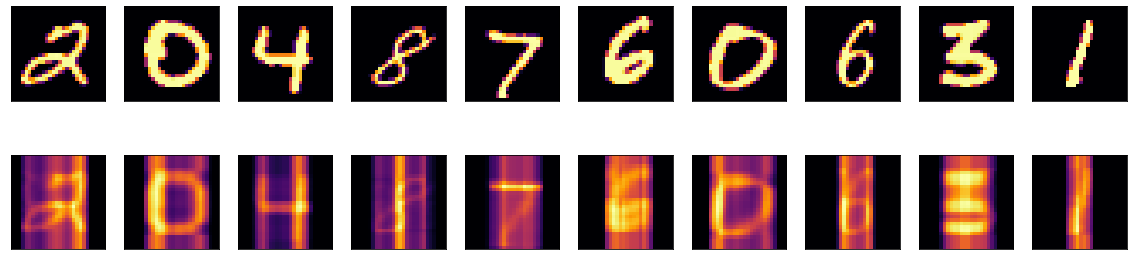

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(20, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, sample in enumerate(mnist_test.take(10)):
  axs[0,i].imshow(sample[0], cmap='inferno')
  axs[1,i].imshow(scaled_dot_product_attention(sample[0], sample[0], sample[0]), cmap='inferno')

fig.show()

In [13]:
num_heads = 3
d_model = 28*num_heads

def build_model(with_mha=True, trainable_mlp=False):
  input = tf.keras.Input(shape=(28,28))

  if with_mha:
    mha = multi_head_attention(input, input, input, d_model)
    output_mha = tf.split(mha, num_heads, axis=-1, name='mha')
    flatten = tf.keras.layers.Flatten()(mha)
  else:
    output_mha = tf.ones_like(input, name='mha')
    print(output_mha)
    flatten = tf.keras.layers.Flatten()(input)

  if trainable_mlp:
    output = tf.keras.layers.Dense(10, activation='softmax', name='class_one_hot')(flatten)
  else:
    output = tf.keras.layers.Dense(10, activation='softmax', name='class_one_hot', trainable=False, use_bias=False, kernel_initializer=tf.keras.initializers.Ones())(flatten)

  model = tf.keras.Model(inputs=input, outputs={'class_one_hot': output, 'mha': output_mha})
  model.summary()
  return model

def plot_test_sample(model, with_mha=True):
  mha_dims = num_heads if with_mha else 1
  fig, axs = plt.subplots(nrows=1+mha_dims, ncols=10, figsize=(20, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

  for i, sample in enumerate(mnist_test.batch(1).take(10)):
    axs[0,i].imshow(sample[0][0], cmap='inferno')
    predicted = model(sample[0])
    if with_mha:
      for j in range(num_heads):
        axs[1+j,i].imshow(predicted['mha'][j][0], cmap='inferno')
    else:
      axs[1,i].imshow(predicted['mha'][0], vmin=0, vmax=1, cmap='inferno')
    print(f'actual: {sample[1][0]}, predicted: {tf.argmax(predicted["class_one_hot"][0])}')

def run_experiment(with_mha=True, trainable_mlp=False, epochs=10):
  model = build_model(with_mha, trainable_mlp)
  mha_metrics = ['accuracy' for i in range(num_heads)] if with_mha else 'accuracy'
  model.compile(optimizer='adam', 
                loss={'class_one_hot': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 'mha':  lambda x,y: 0}, 
                metrics={'class_one_hot': tf.keras.metrics.SparseCategoricalAccuracy(), 'mha': mha_metrics})
  model.fit(mnist_train_batched, validation_data=mnist_test_batched, epochs=epochs)
  return model

#### Does multi-head attention learn?

In [ ]:
mha_only_model = run_experiment(epochs=3)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 28, 84)       2352        input_1[0][0]                    
__________________________________________________________________________________________________
tf.compat.v1.shape (TFOpLambda) (3,)                 0           dense_5[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici ()                   0           tf.compat.v1.shape[0][0]         
______________________________________________________________________________________________

actual: 2, predicted: 0
actual: 0, predicted: 0
actual: 4, predicted: 0
actual: 8, predicted: 0
actual: 7, predicted: 0
actual: 6, predicted: 0
actual: 0, predicted: 0
actual: 6, predicted: 0
actual: 3, predicted: 0
actual: 1, predicted: 0


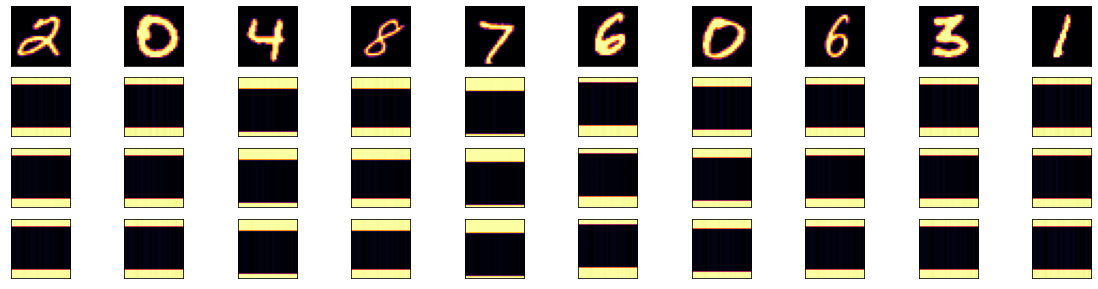

In [ ]:
plot_test_sample(mha_only_model)

#### Does multi-head attention help to learn?

We get a baseline with a single-layer MLP:

In [ ]:
mlp_model = run_experiment(with_mha=False, trainable_mlp=True, epochs=20)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), name='tf.ones_like/ones_like:0', description="created by layer 'tf.ones_like'")
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_2[0][0]                    
__________________________________________________________________________________________________
class_one_hot (Dense)           (None, 10)           7850        flatten_1[0][0]                  
__________________________________________________________________________________________________
tf.ones_like (TFOpLambda) 

actual: 2, predicted: 2
actual: 0, predicted: 0
actual: 4, predicted: 4
actual: 8, predicted: 8
actual: 7, predicted: 7
actual: 6, predicted: 6
actual: 0, predicted: 0
actual: 6, predicted: 6
actual: 3, predicted: 3
actual: 1, predicted: 1


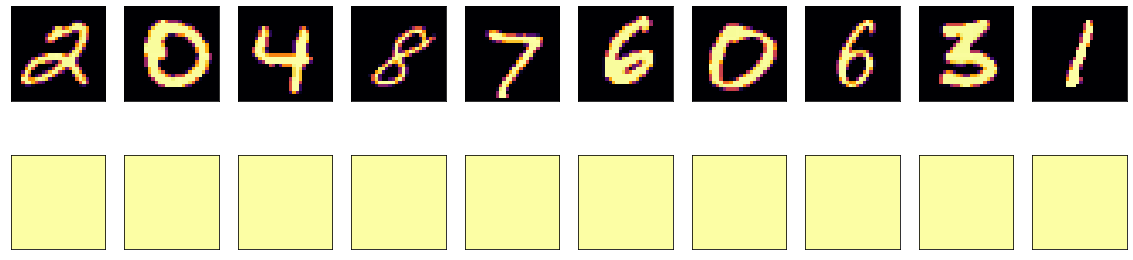

In [ ]:
plot_test_sample(mlp_model, with_mha=False)

#### How does multi-head attention improve learning?

In [ ]:
mha_model = run_experiment(with_mha=True, trainable_mlp=True, epochs=30)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 28, 84)       2352        input_3[0][0]                    
__________________________________________________________________________________________________
tf.compat.v1.shape_1 (TFOpLambd (3,)                 0           dense_9[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli ()                   0           tf.compat.v1.shape_1[0][0]       
____________________________________________________________________________________________

actual: 2, predicted: 2
actual: 0, predicted: 0
actual: 4, predicted: 4
actual: 8, predicted: 8
actual: 7, predicted: 7
actual: 6, predicted: 6
actual: 0, predicted: 0
actual: 6, predicted: 6
actual: 3, predicted: 5
actual: 1, predicted: 1


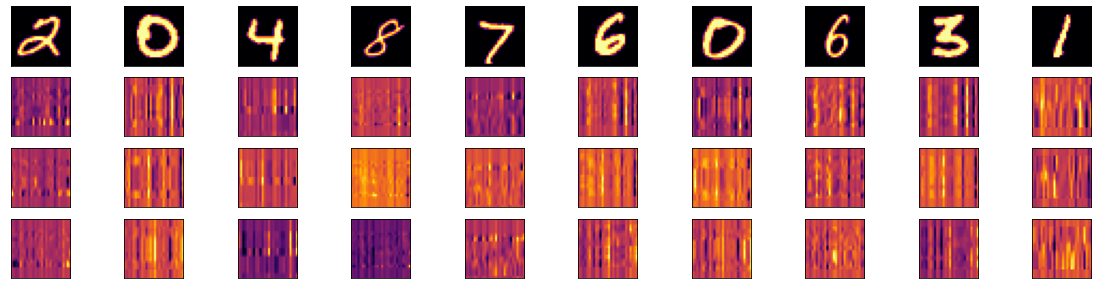

In [ ]:
plot_test_sample(mha_model)